Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\soulf\Anaconda3\envs\hrattrition\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\soulf\Anaconda3\envs\hrattrition\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\soulf\AppData\Local\Temp\ipykernel_6672\2352658031.py", line 96, in fit
  File "C:\Users\soulf\AppData\Local\Temp\ipykernel_6672\2352658031.py", line 152, in decision_function
  File "C:\Users\soulf\AppData\Local\Temp\ipykernel_6672\2352658031.py", line 71, 

Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 500}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       116
           1       0.40      0.71      0.52        24

    accuracy                           0.77       140
   macro avg       0.67      0.75      0.68       140
weighted avg       0.84      0.77      0.79       140

ROC AUC Score: 0.8157327586206896


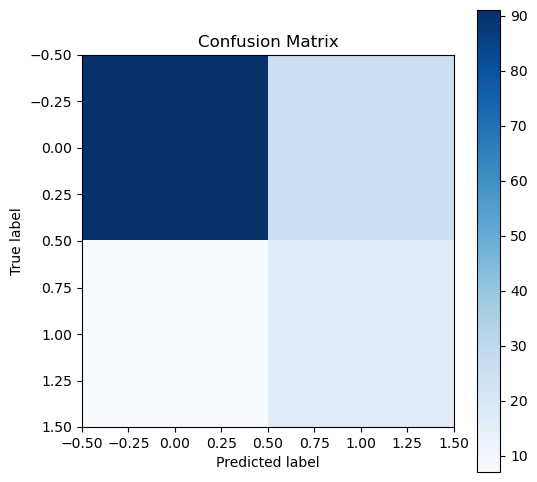

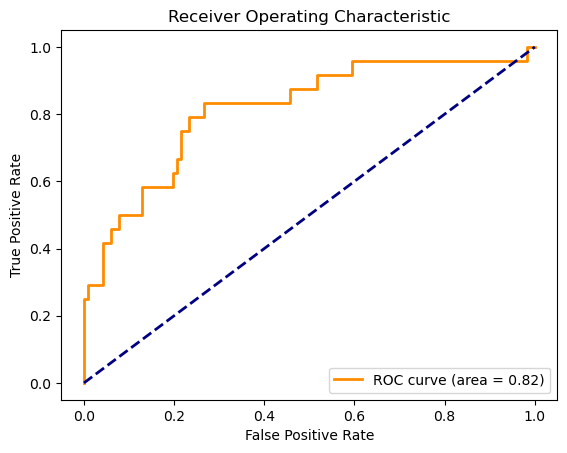

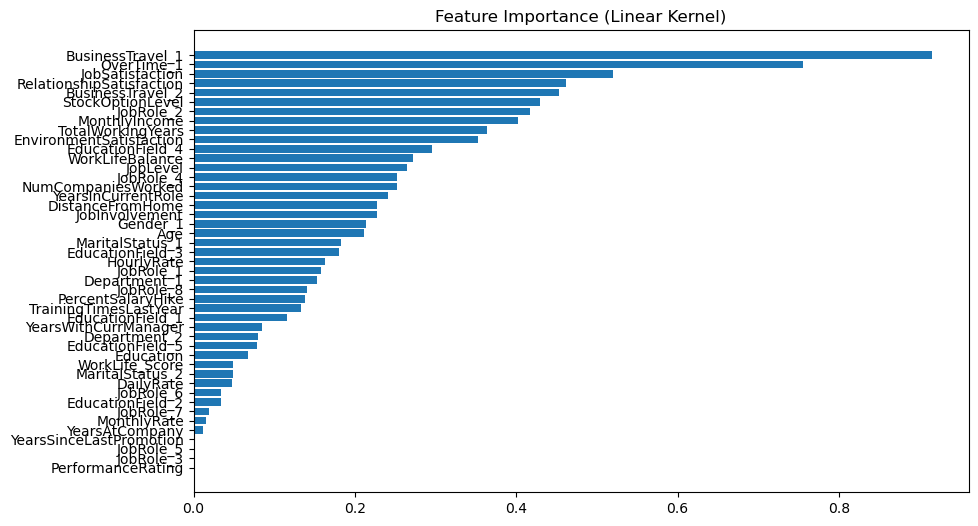

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]
C:\Users\soulf\Anaconda3\envs\hrattrition\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]
C:\Users\soulf\Anaconda3\envs\hrattrition\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training Progress:  13%|█▎        | 64/500 [00:03<00:20, 20.92it/s]


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm

# ======================
# Data Preparation
# ======================

# Load and preprocess data
df = pd.read_csv('HR_Employee_Enhanced.csv')

# Handle categorical variables
df = pd.get_dummies(df, columns=["Department", "EducationField", "Gender", 
                                "JobRole", "MaritalStatus", "OverTime",
                                "BusinessTravel"], drop_first=True)

# Handle class imbalance
X = df.drop("Attrition", axis=1).values
y = df["Attrition"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1], y_train[y_train == 1], 
                               replace=True, n_samples=X_train[y_train == 0].shape[0], random_state=42)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_u)
X_test_scaled = scaler.transform(X_test)

# ======================
# Custom SVM Implementation
# ======================

class CustomSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel='rbf', gamma='scale', degree=3, max_iter=1000, tol=1e-3):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.alpha = None
        self.b = 0
        self.X = None
        self.y = None
        self.kernel_matrix = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_vector_alphas = None
        
    def _kernel(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2.T)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma == 'scale':
                gamma = 1.0 / (self.X.shape[1] * self.X.var())
            else:
                gamma = self.gamma
            return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] - x2, axis=2)**2)
        else:
            raise ValueError("Unsupported kernel type")
    
    def _compute_kernel_matrix(self, X):
        return self._kernel(X, X)
    
    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.X = X
        self.y = y
        
        # Compute kernel matrix
        self.kernel_matrix = self._compute_kernel_matrix(X)
        
        # Simplified SMO optimization
        for _ in tqdm(range(self.max_iter), desc="Training Progress"):
            alpha_prev = np.copy(self.alpha)
            
            for i in range(n_samples):
                Ei = self.decision_function(X[i], X) - y[i]
                
                if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or \
                   (y[i]*Ei > self.tol and self.alpha[i] > 0):
                    
                    j = np.random.choice([k for k in range(n_samples) if k != i])
                    Ej = self.decision_function(X[j], X) - y[j]
                    
                    ai_old = self.alpha[i].copy()
                    aj_old = self.alpha[j].copy()
                    
                    L = max(0, self.alpha[j] - self.alpha[i]) if y[i] != y[j] else \
                        max(0, self.alpha[i] + self.alpha[j] - self.C)
                    H = min(self.C, self.alpha[j] - self.alpha[i] + self.C) if y[i] != y[j] else \
                        min(self.C, self.alpha[i] + self.alpha[j])
                        
                    if L == H:
                        continue
                        
                    eta = 2 * self.kernel_matrix[i, j] - self.kernel_matrix[i, i] - self.kernel_matrix[j, j]
                    if eta >= 0:
                        continue
                        
                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    
                    if abs(self.alpha[j] - aj_old) < 1e-5:
                        continue
                        
                    self.alpha[i] += y[i] * y[j] * (aj_old - self.alpha[j])
                    
                    b1 = self.b - Ei - y[i]*(self.alpha[i]-ai_old)*self.kernel_matrix[i,i] \
                         - y[j]*(self.alpha[j]-aj_old)*self.kernel_matrix[i,j]
                    b2 = self.b - Ej - y[i]*(self.alpha[i]-ai_old)*self.kernel_matrix[i,j] \
                         - y[j]*(self.alpha[j]-aj_old)*self.kernel_matrix[j,j]
                    
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2)/2
                        
            # Check convergence
            if np.linalg.norm(self.alpha - alpha_prev) < self.tol:
                break
                
        # Store support vectors
        self.support_vectors = X[self.alpha > 0]
        self.support_vector_labels = y[self.alpha > 0]
        self.support_vector_alphas = self.alpha[self.alpha > 0]
        return self
    
    def decision_function(self, X, X_sv=None):
        if X_sv is None:
            X_sv = self.X
        kernel_values = self._kernel(X, X_sv)
        return np.dot(kernel_values, (self.alpha * self.y)) + self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X)).astype(int)
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

# ======================
# Hyperparameter Tuning
# ======================

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1, 1],
    'degree': [2, 3],
    'max_iter': [500]
}

grid_search = GridSearchCV(CustomSVM(), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled[:1000], y_train_u[:1000])  # Reduced for demonstration

print("Best parameters:", grid_search.best_params_)
best_svm = grid_search.best_estimator_

# ======================
# Model Evaluation
# ======================

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Predictions
y_pred = best_svm.predict(X_test_scaled)
y_score = best_svm.decision_function(X_test_scaled)

# Convert labels back to 0/1
y_pred = np.where(y_pred == -1, 0, 1)

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_score))

# Visualizations
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_score)

# ======================
# Feature Importance Analysis
# ======================

def plot_feature_importance(model, feature_names):
    if model.kernel == 'linear':
        weights = np.dot(model.alpha * model.y, model.X)
        importance = np.abs(weights)
        sorted_idx = np.argsort(importance)
        
        plt.figure(figsize=(10,6))
        plt.barh(range(len(sorted_idx)), importance[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.title("Feature Importance (Linear Kernel)")
        plt.show()
    else:
        print("Feature importance only available for linear kernel")

feature_names = df.drop("Attrition", axis=1).columns.tolist()
plot_feature_importance(best_svm, feature_names)

# ======================
# Learning Curve Visualization
# ======================

def plot_learning_curve(train_sizes, train_scores, test_scores):
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

# Learning curve data collection
train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(size * X_train_scaled.shape[0])
    
    svm = CustomSVM(**grid_search.best_params_)
    svm.fit(X_train_scaled[:n_samples], y_train_u[:n_samples])
    
    train_pred = svm.predict(X_train_scaled[:n_samples])
    test_pred = svm.predict(X_test_scaled)
    
    train_scores.append(f1_score(y_train_u[:n_samples], train_pred))
    test_scores.append(f1_score(y_test, test_pred))

plot_learning_curve(train_sizes * X_train_scaled.shape[0], train_scores, test_scores)

In [ ]:
# After running the SVM model code in HR_Project_SVM.ipynb

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['No Attrition', 'Attrition'])
plt.yticks(tick_marks, ['No Attrition', 'Attrition'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Learning Curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes * X_train_scaled.shape[0], train_scores, 'o-', label="Training Score")
plt.plot(train_sizes * X_train_scaled.shape[0], test_scores, 'o-', label="Cross-validation Score")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.title("SVM Learning Curve")
plt.legend()
plt.show()